In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from uti.newLeaner_05b import *

In [3]:
train_ds,valid_ds = get_dataset(*get_data())
data = Databunch(*get_dl(train_ds,valid_ds,bs=64),c=10)
loss_func = F.cross_entropy

/home/jupyter/.fastai/data/mnist.pkl.gz


In [105]:
#export
class Recorder(Callback):
    _order = 1
    
    def __init__(self,beta=0.9):
        self.beta = beta
        self.losses, self.lrs = [], []
        self.avg_loss = 0.
        self.count = 0    
        
    def begin_batch(self):
        self.count += 1
    
    def after_loss(self):
        if self.learn.in_train:
            with torch.no_grad():
                self.losses.append(self.smooth_loss())
                self.lrs.append(self.learn.opt.param_groups[0]['lr'])
            
    def smooth_loss(self):
        loss = self.learn.loss.item()
        self.avg_loss = self.avg_loss * self.beta + loss * (1-self.beta)
        smooth_loss = self.avg_loss / (1-self.beta ** self.count)
        return smooth_loss
         
            
    def plot_lr(self):
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)

In [5]:
learn = NewLearner(*get_model(data),loss_func,data,cbs=[Recorder(),Accuracy()])

In [6]:
learn.fit(2)

Train: 0.3176969587802887, 0.9023200273513794
Valid: 0.2603795528411865, 0.9192000031471252
 
Train: 0.14280273020267487, 0.9574400186538696
Valid: 0.20380842685699463, 0.9352999925613403
 


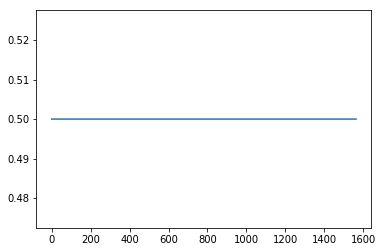

In [7]:
learn.cbs[2].plot_lr()

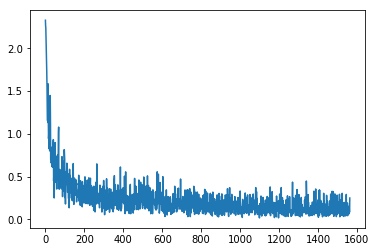

In [8]:
learn.cbs[2].plot_loss()

Recorder works fine, now we just need to re implement LR_find using new Leaner

In [9]:
#export
class LR_find(Callback):
    def begin_fit(self,start=1e-8,end=10.,beta=0.98):
        self.start, self.end, self.beta = start, end, beta
        self.current_lr = start
        self.ratio = (end / start) ** (1 / (len(self.learn.data.train_dl)-1))
        self.lr = []
        self.losses = []
        self.best_loss = 0.
        self.avg_loss = 0.
        self.smooth_loss = 0.
        self.batch_num = 0
        
    def begin_batch(self):
        self.batch_num += 1
        self.learn.opt.param_groups[0]['lr'] = self.current_lr
        
    
    def after_loss(self):
        self.loss = self.learn.loss
        self.avg_loss = self.avg_loss * self.beta + self.loss.data * (1 - self.beta)
        self.smooth_loss = self.avg_loss / (1 - self.beta ** self.batch_num) #debias
        if self.batch_num > 1 and self.smooth_loss > 4 * self.best_loss:
            raise CancelTrainException()
        if self.batch_num == 1 or self.best_loss > self.smooth_loss:
            self.best_loss = self.smooth_loss
            self.best_lr = self.current_lr
        self.losses.append(self.smooth_loss)
        self.lr.append(math.log10(self.current_lr))
        self.current_lr *= self.ratio
        
    
    def begin_validate(self):
        raise CancelTrainException()

In [10]:
lr_find = LR_find()
learn = NewLearner(*get_model(data),loss_func,data,cbs=[lr_find])

In [11]:
learn.fit(1)

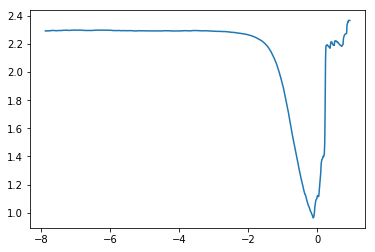

In [12]:
plt.plot(lr_find.lr[10:-5],lr_find.losses[10:-5])

In [54]:
#export
class ParaScheduler(Callback):
    _order = 1
    def __init__(self,para_name,sched_func):
        self.para_name, self.sched_func = para_name, sched_func
        
    def set_param(self,pos):
        self.learn.opt.param_groups[0][self.para_name] = self.sched_func(pos)
        
    def begin_batch(self):
        if self.learn.in_train:
            
            #cbs[0] will always be TrainEvalCallback
            #TrainEval will have current pos, eg: 2.3 epochs
            #pos = current_epochs / total_epochs, eg: 20% of training 
            
            pos = self.learn.cbs[0].n_epochs / self.learn.epochs 
            self.set_param(pos)

In [19]:
#export
from functools import partial
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos):  return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [21]:
f = sched_lin(1,2)

In [22]:
f(0.3)

1.3

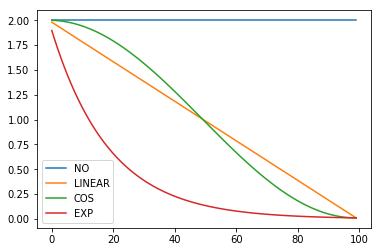

In [30]:
annealings = "NO LINEAR COS EXP".split()

torch.Tensor.ndim = property(lambda x: len(x.shape))

a = torch.arange(0,100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [34]:
#export
#copied from class
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + pcts)
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [114]:
f = combine_scheds([0.3,0.7],[sched_cos(0.3,0.9),sched_cos(0.9,0.2)])

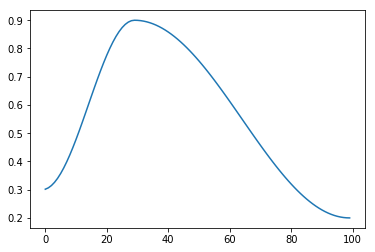

In [115]:
plt.plot(a,[f(o) for o in p])

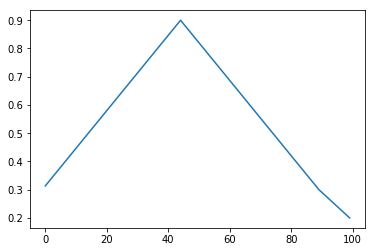

In [121]:
f_lin = combine_scheds([0.45,0.45,0.1],[sched_lin(0.3,0.9),sched_lin(0.9,0.3),sched_lin(0.3,0.2)])
plt.plot(a,[f_lin(o) for o in p])

In [116]:
cbs = [Recorder(),Accuracy(),ParaScheduler('lr',f)]

In [117]:
learn = NewLearner(*get_model(data),loss_func,data,cbs=cbs)

In [118]:
learn.fit(3)

Train: 0.3736019432544708, 0.8867400288581848
Valid: 0.5682228207588196, 0.8481000065803528
 
Train: 0.16054372489452362, 0.9517599940299988
Valid: 0.1863071471452713, 0.9442999958992004
 
Train: 0.08656993508338928, 0.9740599989891052
Valid: 0.09830653667449951, 0.9724000096321106
 


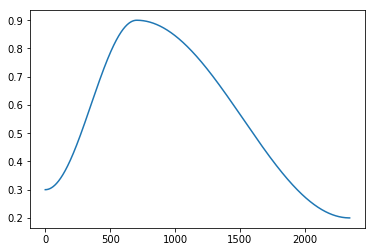

In [119]:
learn.cbs[2].plot_lr()

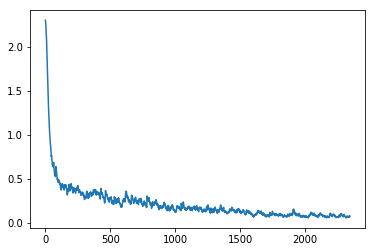

In [120]:
learn.cbs[2].plot_loss()

In [122]:
cbs = [Recorder(),Accuracy(),ParaScheduler('lr',f_lin)]
learn = NewLearner(*get_model(data),loss_func,data,cbs=cbs)
learn.fit(3)

Train: 0.35432305932044983, 0.8922799825668335
Valid: 0.18321143090724945, 0.9455999732017517
 
Train: 0.16779112815856934, 0.9487000107765198
Valid: 0.1548624187707901, 0.9542999863624573
 
Train: 0.09236268699169159, 0.9722800254821777
Valid: 0.09826429188251495, 0.9717000126838684
 


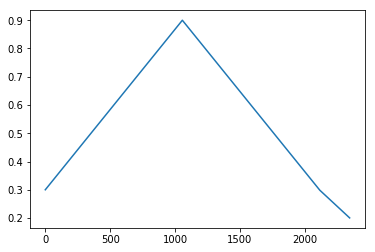

In [123]:
learn.cbs[2].plot_lr()

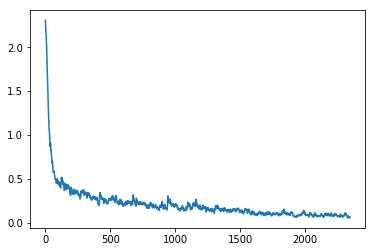

In [124]:
learn.cbs[2].plot_loss()

# Fin

Done Param scheduler, test both linear scheduler and cos scheduler, seems cos schduler is good for now.
Will re-test both after batch_norm is included and longer training time

Minor changes to Recorder, now for the loss it is ploting the exponential moving avager with beta set to 0.9 by default, roughly 10 data average window.

In [125]:
from notebook2script import *

In [127]:
notebook2script('05c_LR_Scheduler.ipynb','LR_find_Schduler')

Converted 05c_LR_Scheduler.ipynb to uti/LR_find_Schduler_05c.py
